In [1]:
# Author: Laura Kulowski


#files
import sys
#from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
#from os.path import isfile, join

#own libs
import utils
import caract as dc
import dataset as ds
import generate_dataset as gd
import plotting


#data and visualization
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

sns.set_style("darkgrid")


import numpy as np
import random
import os, errno
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **redes**

In [ ]:

#encoder class
class lstm_encoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers = 1):

        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x_input):

        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))

        return lstm_out, self.hidden
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


# decoder class
class lstm_decoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x_input, hidden_state):

        lstm_out, self.hidden = self.lstm(x_input, hidden_state)
        output = self.fc(lstm_out.squeeze(0))

        return output, self.hidden
    

In [ ]:
#full class
class lstm_seq2seq(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(lstm_seq2seq, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size, hidden_size)
        self.decoder = lstm_decoder(input_size, hidden_size)
    
    def train_model(self, input_tensor, target_tensor, n_epochs, target_len, batch_size, training_prediction = 'recursive', teacher_forcing_ratio = 0.5, learning_rate = 0.01, dynamic_tf = False):
        
        '''
        train lstm encoder-decoder
        
        : param input_tensor:              input data with shape (seq_len, # in batch, number features); PyTorch tensor    
        : param target_tensor:             target data with shape (seq_len, # in batch, number features); PyTorch tensor
        : param n_epochs:                  number of epochs 
        : param target_len:                number of values to predict 
        : param batch_size:                number of samples per gradient update
        : param training_prediction:       type of prediction to make during training ('recursive', 'teacher_forcing', or
        :                                  'mixed_teacher_forcing'); default is 'recursive'
        : param teacher_forcing_ratio:     float [0, 1) indicating how much teacher forcing to use when
        :                                  training_prediction = 'teacher_forcing.' For each batch in training, we generate a random
        :                                  number. If the random number is less than teacher_forcing_ratio, we use teacher forcing.
        :                                  Otherwise, we predict recursively. If teacher_forcing_ratio = 1, we train only using
        :                                  teacher forcing.
        : param learning_rate:             float >= 0; learning rate
        : param dynamic_tf:                use dynamic teacher forcing (True/False); dynamic teacher forcing
        :                                  reduces the amount of teacher forcing for each epoch
        : return losses:                   array of loss function for each epoch
        '''
        
        # initialize array of losses 
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                
                batch_loss = 0.
                batch_loss_tf = 0.
                batch_loss_no_tf = 0.
                num_tf = 0
                num_no_tf = 0

                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    if training_prediction == 'recursive':
                        # predict recursively
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = decoder_output

                    if training_prediction == 'teacher_forcing':
                        # use teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = target_batch[t, :, :]

                        # predict recursively 
                        else:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = decoder_output

                    if training_prediction == 'mixed_teacher_forcing':
                        # predict using mixed teacher forcing
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            
                            # predict with teacher forcing
                            if random.random() < teacher_forcing_ratio:
                                decoder_input = target_batch[t, :, :]
                            
                            # predict recursively 
                            else:
                                decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    batch_loss += loss.item()
                    
                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss

                # dynamic teacher forcing
                if dynamic_tf and teacher_forcing_ratio > 0:
                    teacher_forcing_ratio = teacher_forcing_ratio - 0.02 

                # progress bar 
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))
                    
        return losses

    def predict(self, input_tensor, target_len):
        
        '''
        : param input_tensor:      input data (seq_len, input_size); PyTorch tensor 
        : param target_len:        number of target values to predict 
        : return np_outputs:       np.array containing predicted values; prediction done recursively 
        '''

        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs


## **archivos**

In [4]:
fpath = "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
fname = "file1_050124.mat"
cutoff = [8/1000, 11/1000]

mat = ds.MatFileToDataFrame(fpath, fname)

df_ = mat.get_dataframe(cutoff)

x = dc.CaractDefect(df_)
taus = x.get_tau()[1]

hilbert, _ = x.get_hilbert()

df = pd.merge(df_, hilbert, on = 'Hilbert Transform', how = 'outer')

df.head()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,2.256644,0.049758,0.007786,0.007786-0.004629j,0.009058,-0.536394,-0.056599
1,2.258288,0.051402,0.007361,0.007361+0.000726j,0.007397,0.098350,-0.028915
2,2.260261,0.053375,0.006933,0.006933+0.001102j,0.007020,0.157607,-0.002832
3,2.260918,0.054033,0.006502,0.006502+0.003041j,0.007178,0.437517,0.020193
4,2.262233,0.055348,0.006068,0.006068+0.003316j,0.006915,0.500092,0.039028


## **dataset para red**

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

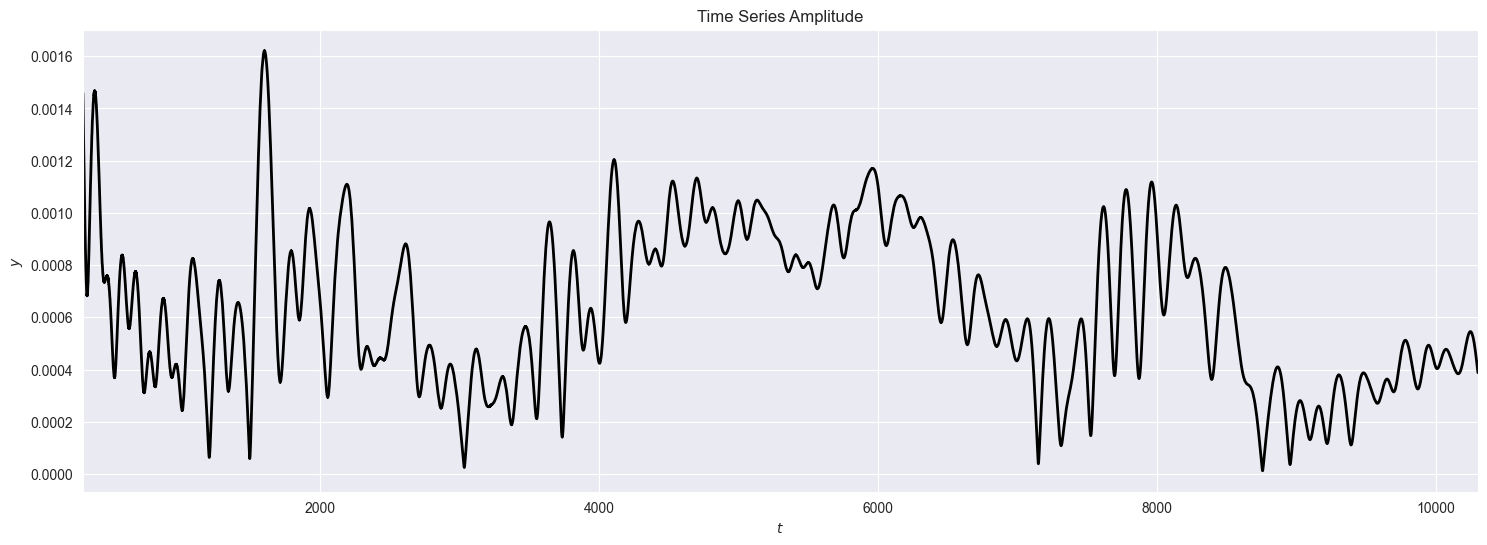

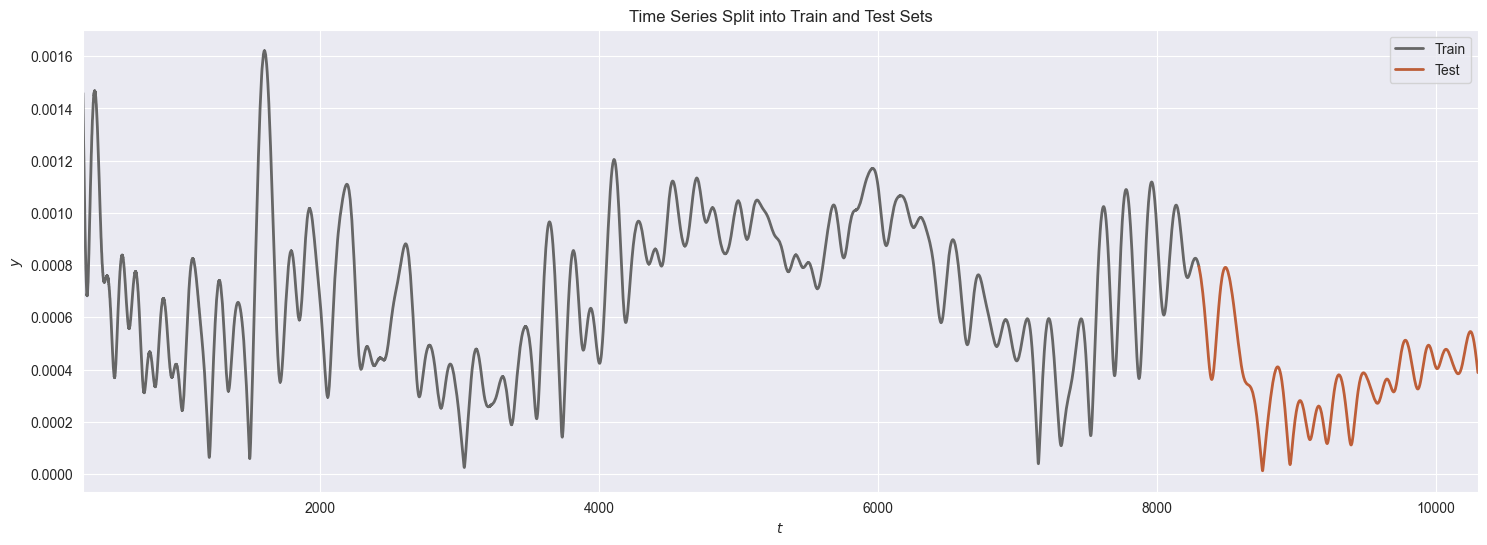

In [10]:
t, y = df.index.values[300:10300] , df['Amplitude'].values[300:10300]

t_train, y_train, t_test, y_test = gd.train_test_split(t, y, 0.8)

#plot
plt.figure(figsize = (18, 6))
plt.plot(t, y, color = 'k', linewidth = 2)
plt.xlim([t[0], t[-1]])
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.title('Time Series Amplitude')

# plot time series with train/test split
plt.figure(figsize = (18, 6))
plt.plot(t_train, y_train, color = '0.4', linewidth = 2, label = 'Train') 
plt.plot(np.concatenate([[t_train[-1]], t_test]), np.concatenate([[y_train[-1]], y_test]),
         color = (0.74, 0.37, 0.22), linewidth = 2, label = 'Test')
plt.xlim([t[0], t[-1]])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Time Series Split into Train and Test Sets')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout
#plt.savefig('plots/train_test_split.png')


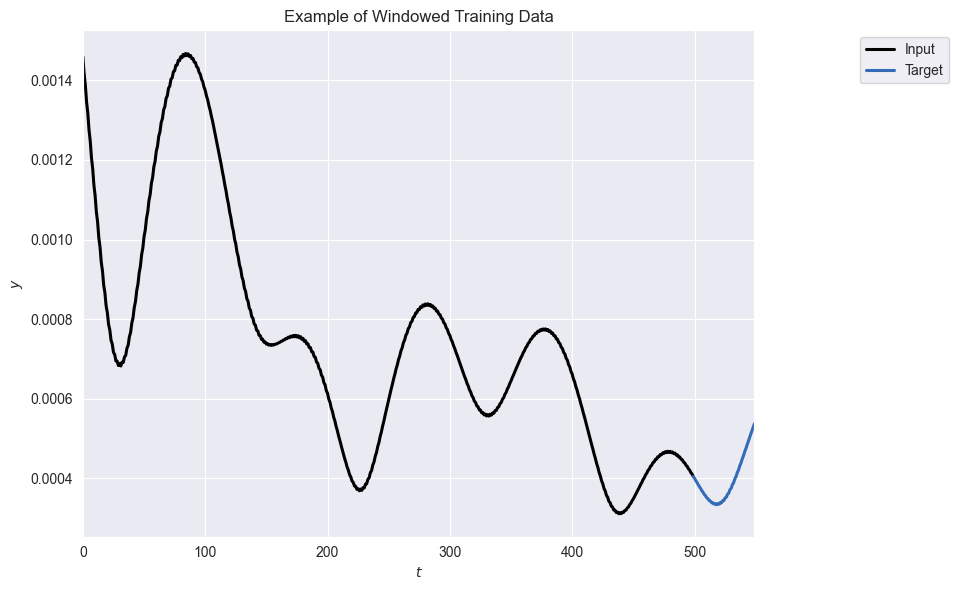

In [11]:
# window dataset

iw = 500
ow = 50
s = 5

Xtrain, ytrain =  gd.windowed_dataset(y_train, iw, ow, s)
Xtest, ytest =  gd.windowed_dataset(y_test, iw, ow, s)

# plot
plt.figure(figsize = (10, 6)) 
plt.plot(np.arange(0, iw), Xtrain[:, 0, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[Xtrain[-1, 0, 0]], ytrain[:, 0, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Training Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout()